# VGG--19

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
data = keras.utils.image_dataset_from_directory(r'D:/QuantumProject/Only_dataset/brain_tumor_dataset')

# Divide the dataset into train, validation, and test sets
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.2) + 1

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Define the VGG-19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, epochs=15, validation_data=val)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)




Found 3000 files belonging to 2 classes.



Epoch 1/50


56/56 [==============================] - 3280s 59s/step - loss: 3.2388 - accuracy: 0.8890 - val_loss: 0.4549 - val_accuracy: 0.9655
Epoch 2/50
56/56 [==============================] - 1568s 28s/step - loss: 0.3668 - accuracy: 0.9704 - val_loss: 1.1759 - val_accuracy: 0.9424
Epoch 3/50
56/56 [==============================] - 1590s 28s/step - loss: 0.2842 - accuracy: 0.9844 - val_loss: 0.3003 - val_accuracy: 0.9918
Epoch 4/50
56/56 [==============================] - 1564s 28s/step - loss: 0.3635 - accuracy: 0.9754 - val_loss: 0.4872 - val_accuracy: 0.9803
Epoch 5/50
56/56 [==============================] - 1338s 24s/step - loss: 0.0936 - accuracy: 0.9944 - val_loss: 0.4979 - val_accuracy: 0.9901
Epoch 6/50
56/56 [==============================] - 698s 12s/step - loss: 0.0574 - accuracy: 0.9933 - val_loss: 0.4174 - val_accuracy: 0.9836
Epoch 7/50
56/56 [==============================] - 691s 12s/step - loss: 0.1183 - accuracy: 0.9

56/56 [==============================] - 687s 12s/step - loss: 2.3964e-08 - accuracy: 1.0000 - val_loss: 0.6028 - val_accuracy: 0.9918
Epoch 49/50
56/56 [==============================] - 701s 13s/step - loss: 2.2703e-08 - accuracy: 1.0000 - val_loss: 0.1483 - val_accuracy: 0.9951
Epoch 50/50
19/19 [==============================] - 174s 9s/step - loss: 0.6215 - accuracy: 0.9867
Test Loss: 0.6214537620544434
Test Accuracy: 0.9866666793823242


1/1 [==============================] - 7s 7s/step
F1 Score: 0.9899665551839465
ROC-AUC Score: 0.9944499383326483


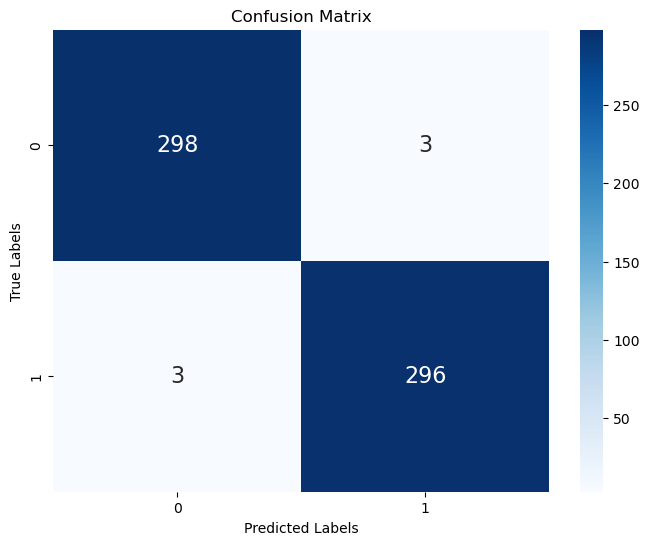

In [3]:
# Predictions
y_true_list = []
y_pred_list = []

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    y_true_list.append(y)
    y_pred_list.append(yhat)

y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

# Calculate metrics
f1 = f1_score(y_true, (y_pred > 0.5).astype(int))
roc_auc = roc_auc_score(y_true, y_pred)

# Print metrics
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc)

# Calculate confusion matrix
cm = confusion_matrix(y_true, (y_pred > 0.5).astype(int))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 7s 7s/step
Accuracy: 0.98833334
Recall: 0.98644066
Precision: 0.9897959
F1 Score: 0.9881154499151105
ROC-AUC Score: 0.9945484856904696


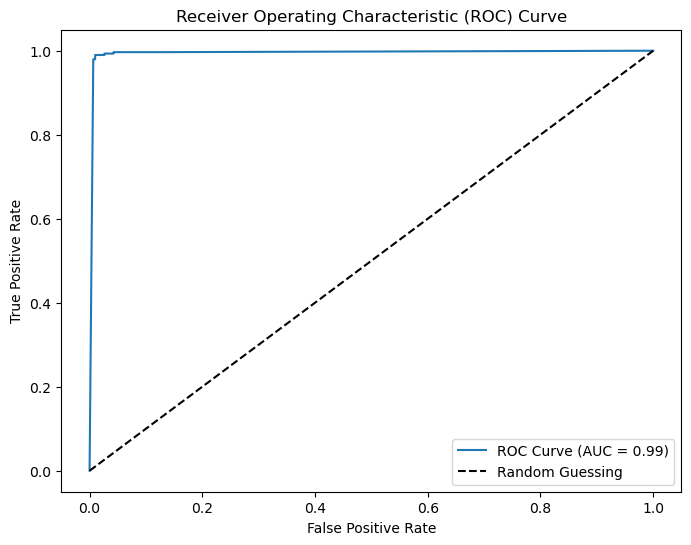

In [4]:
# Evaluate the model
bin_acc = keras.metrics.BinaryAccuracy()
recall = keras.metrics.Recall()
precision = keras.metrics.Precision()
y_true_list = []
y_pred_list = []

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    bin_acc.update_state(y, yhat)
    recall.update_state(y, yhat)
    precision.update_state(y, yhat)

    y_true_list.append(y)
    y_pred_list.append(yhat)

y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

roc_auc = roc_auc_score(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Print evaluation metrics
print("Accuracy:", bin_acc.result().numpy())
print("Recall:", recall.result().numpy())
print("Precision:", precision.result().numpy())
print("F1 Score:", f1_score(y_true, (y_pred > 0.5).astype(int)))
print("ROC-AUC Score:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [5]:
# Calculate True Positive (TP), True Negative (TN), False Positive (FP), False Negative (FN)
TP = np.sum((y_true == 1) & (y_pred > 0.5))
TN = np.sum((y_true == 0) & (y_pred <= 0.5))
FP = np.sum((y_true == 0) & (y_pred > 0.5))
FN = np.sum((y_true == 1) & (y_pred <= 0.5))

# Calculate Sensitivity and Specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)


Sensitivity: 0.49
Specificity: 0.51
